In [ ]:
%load_ext autoreload
%autoreload 2
# SPARC-15-F
# Sparc-12-M
# Sparc-13-M
# Sparc-14-M
# Sparc-15-M
mapping = {
    "SPARC-10-M":"EEG 1", 
    "SPARC-11-M":"EEG 1",
    "SPARC-12-M":"EEG 1",
    "SPARC-13-M":"EEG 1",
    "SPARC-14-M":"EEG 1",
    "SPARC-15-M":"EEG 1",
    "SPARC-17-M":"EEG 2",
    "SPARC-18-M":"EEG 1",
    "SPARC-2-F":"EEG 1",
    "SPARC-4-F":"EEG 1",
    "SPARC-5-F":"Channel-2",
    "SPARC-8-F":"Channel-10",
    "SPARC-9-F ":"Channel-2",
    "SPARC-10-F":"Channel-50",
    "SPARC-11-F":"Channel-18",
    "SPARC-12-F":"Channel-42",
    "SPARC-13-F":"EEG 1",
    "SPARC-14-F":"EEG 1",
    "SPARC-15-F":"EEG 1",
    "SPARC-16-F":"EEG 2"
}

In [ ]:
from lib.utils import *
from lib.models import *
from lib.ekyn import *
from lib.env import *
from lib.datasets import *

class FeatureSet(Dataset):
    def __init__(self,X):
        self.len = len(X)
        self.X = cat([zeros(4,5000),X,zeros(4,5000)])

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.X[idx:idx+9].flatten()

In [41]:
import os
files = os.listdir(f'{DATA_PATH}/icv/edf')
print(files)
file = 'SPARC-10-M'
raw = read_raw_edf(f'{DATA_PATH}/icv/edf/{file}.edf',verbose=False)

['SPARC-15-M.edf', 'SPARC-12-F.edf', 'SPARC-13-F.edf', 'SPARC-10-M.edf', 'SPARC-12-M.edf', 'SPARC-17-M.edf', 'SPARC-14-M.edf', 'SPARC-4-F.edf', 'SPARC-16-F.edf', 'SPARC-13-M.edf', 'SPARC-9-F.edf', 'SPARC-11-M.edf', 'SPARC-18-M.edf', 'SPARC-5-F.edf', 'SPARC-10-F.edf', 'SPARC-15-F.edf', 'SPARC-8-F.edf', 'SPARC-11-F.edf', 'SPARC-2-F.edf', 'SPARC-20-M.edf', 'SPARC-14-F.edf']


/tmp/ipykernel_1012308/3269398946.py:5: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG 1 [PL: 60Hz]'}. Applying running numbers for duplicates.
  raw = read_raw_edf(f'{DATA_PATH}/icv/edf/{file}.edf',verbose=False)


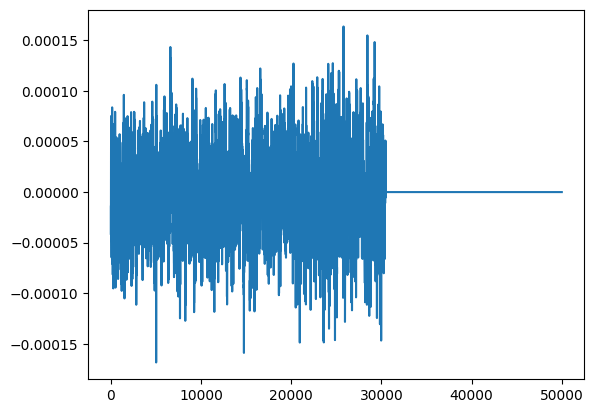

In [44]:
eeg = raw.get_data(picks=mapping[file])
plt.plot(eeg.reshape(-1,5000)[:10].flatten())

In [45]:
model = Gandalf()
model.load_state_dict(torch.load(f=f'../models/gandalfs/gandalf_0/best_model.pt',map_location='cpu'))
model.to(DEVICE);

In [46]:
eeg = eeg.reshape(-1,5000)
eeg = torch.from_numpy(eeg).float()
print(eeg.shape)
dataloader = DataLoader(dataset=FeatureSet(eeg),batch_size=32,shuffle=False)

torch.Size([74533, 5000])


In [47]:
def score(dataloader,model,DEVICE=DEVICE):
    with torch.no_grad():
        y_pred = torch.Tensor()
        y_logits = torch.Tensor()
        for Xi in tqdm(dataloader):
            Xi = Xi.to(DEVICE)
            logits = model(Xi)
            y_logits = torch.cat([y_logits,torch.softmax(logits,dim=1).detach().cpu()])
            y_pred = torch.cat([y_pred,torch.softmax(logits,dim=1).argmax(axis=1).detach().cpu()])
    return y_pred,y_logits

In [48]:
y_pred,y_logits = score(dataloader,model)

100%|██████████| 2330/2330 [01:30<00:00, 25.62it/s]


In [40]:
torch.bincount(y_pred.long())

tensor([24606,    23, 36032])

In [ ]:
path = f'../data/ICV/csv'
import os
for file in os.listdir(f'{path}'):
    df = pd.read_csv(f'{path}/{file}')
    print(df['0'].value_counts(normalize=True))